# Statistical Arbitrage: Cointegration on Tech Stocks
## Objective: Identify cointegrated stock pairs in a 12-stock tech universe and backtest a z-score mean-reversion market-neutral strategy.

### Imports and Configurations

In [1]:
import os
import json
from datetime import datetime

import numpy as np
import pandas as pd
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({"figure.figsize": (12, 6)})
sns.set_style("whitegrid")

# --- Config ---
RUN_ID = datetime.now().strftime("%Y%m%d_%H%M%S")
CONFIG = {
    "prices_csv": "pair_data.csv",      # path to CSV file
    "date_col": "Unnamed: 0",           # date column in the dataset
    "min_obs": 252,                     # minimum observations for cointegration
    "train_window": 252,                # window for cointegration/z-score (days)
    "step_days": 21,                    # step between windows in the rolling scan
    "entry_z": 2.0,                     # z-score to enter
    "exit_z": 0.5,                      # z-score to exit
    "transaction_cost": 0.001,          # round-trip proportion of notional
    "top_pairs": 5,                     # number of pairs to trade
    "risk_free_daily": 0.0,             # daily risk-free, used in Sharpe if needed
    "out_dir": f"artifacts/run_{RUN_ID}"# timestamped output directory
}

os.makedirs(CONFIG["out_dir"], exist_ok=True)
PLOTS_DIR = os.path.join(CONFIG["out_dir"], "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs("outputs", exist_ok=True)

### Helpers

In [2]:
def save_df(df, fname):
    df.to_csv(os.path.join(CONFIG["out_dir"], fname), index=True)

def to_log(price_df):
    return np.log(price_df)

def zscore(series):
    return (series - series.mean()) / series.std(ddof=0)

# plotting helper: save + show
def save_and_show(fig, name):
    path = os.path.join(PLOTS_DIR, f"{name}.png")
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved plot: {path}")

### Loading and Cleaning Prices

In [3]:
prices = pd.read_csv(
    CONFIG["prices_csv"],
    parse_dates=[CONFIG["date_col"]]
)

prices = prices.sort_values(CONFIG["date_col"]).set_index(CONFIG["date_col"])
prices = prices.loc[:, prices.isna().mean() < 0.2]         # drop cols with >20% NaNs
prices = prices.loc[:, prices.nunique() > 1]               # drop constant cols
prices = prices.ffill().dropna()                           # forward-fill then drop remaining NaNs
prices = prices.loc[:, (prices > 0).all()]                 # ensure positive prices

print(f"✅ Loaded prices: {prices.shape[0]} rows × {prices.shape[1]} assets")
display(prices.head())

✅ Loaded prices: 1403 rows × 12 assets


,AAPL,MSFT,GOOG,META,NVDA,AMD,INTC,ADBE,ORCL,CRM,CSCO,QCOM
Unnamed: 0,,,,,,,,,,,,
2020-01-02,72.627853,153.036124,67.961588,208.648584,5.971845,49.10,53.666888,334.43,49.545134,165.511180,40.933310,78.522280
2020-01-03,71.921766,151.130557,67.628085,207.544571,5.876259,48.60,53.014135,331.81,49.370647,164.698441,40.265460,77.043734
2020-01-06,72.494857,151.521198,69.295601,211.453375,5.900902,48.39,52.864178,333.71,49.627785,171.913972,40.409175,76.592202
2020-01-07,72.153904,150.139662,69.252360,211.910894,5.972343,48.25,51.982079,333.39,49.737988,174.441390,40.147107,78.770179
2020-01-08,73.314596,152.531149,69.798092,214.059244,5.983544,47.83,52.017363,337.87,49.930842,175.759611,40.172468,78.539987


### Basic EDA

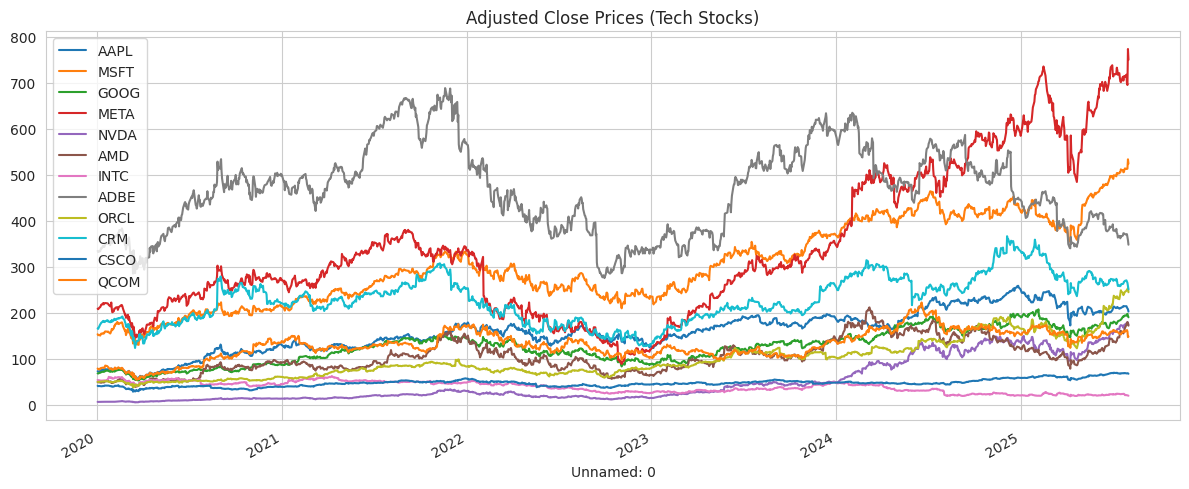

✅ Saved plot: artifacts/run_20250916_183216/plots/prices_timeseries.png


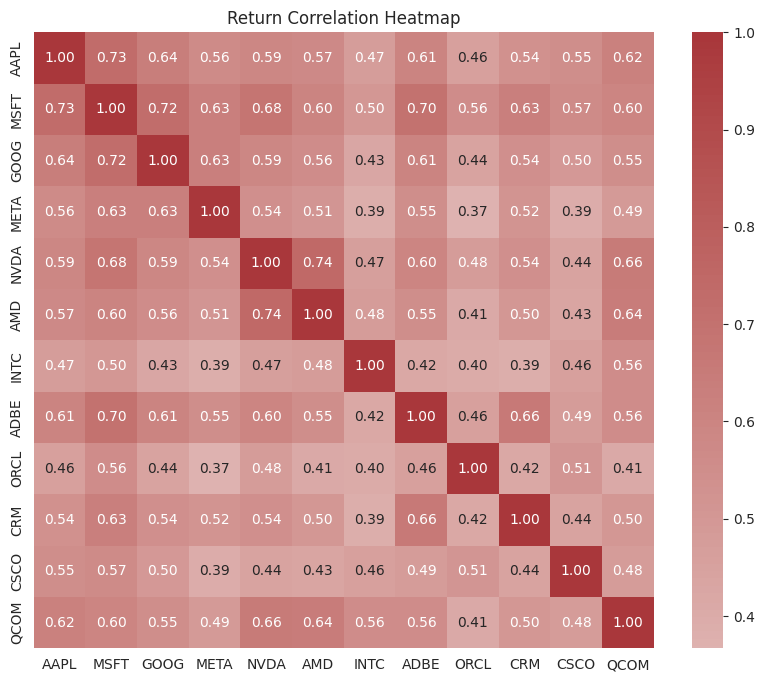

✅ Saved plot: artifacts/run_20250916_183216/plots/correlation_heatmap.png


In [24]:
fig, ax = plt.subplots(figsize=(12,5))
prices.plot(ax=ax, title="Adjusted Close Prices (Tech Stocks)")
plt.tight_layout()
save_and_show(fig, "prices_timeseries")

returns = prices.pct_change().dropna()
fig = plt.figure(figsize=(10,8))
sns.heatmap(returns.corr(), annot=True, fmt=".2f", cmap="vlag", center=0)
plt.title("Return Correlation Heatmap")
save_and_show(fig, "correlation_heatmap")

### Engle–Granger on a Single Window

In [5]:
def engle_granger_pair(pr1_log, pr2_log):
    """OLS pr1 ~ pr2; ADF on spread. Inputs are log-prices (aligned Series)."""
    X = sm.add_constant(pr2_log)
    res = sm.OLS(pr1_log, X).fit()
    beta = res.params.iloc[1]
    spread = pr1_log - beta * pr2_log
    try:
        adf_stat, pvalue, *_ = adfuller(spread, regression='c', autolag='AIC')
    except Exception:
        adf_stat, pvalue = np.nan, np.nan
    return {"beta": beta, "adf_stat": adf_stat, "adf_pvalue": pvalue, "spread": spread}

tickers = prices.columns.tolist()
logp = to_log(prices)

pairs = []
for a, b in itertools.combinations(tickers, 2):
    out = engle_granger_pair(logp[a], logp[b])
    pairs.append({
        "ticker_a": a,
        "ticker_b": b,
        "beta": out["beta"],
        "adf_stat": out["adf_stat"],
        "adf_pvalue": out["adf_pvalue"]
    })
pairs_df = pd.DataFrame(pairs).sort_values("adf_pvalue")
pairs_df.to_csv("outputs/pairs_single_window.csv", index=False)
display(pairs_df.head(10))

,ticker_a,ticker_b,beta,adf_stat,adf_pvalue
17,MSFT,ORCL,0.718127,-3.440234,0.009661
19,MSFT,CSCO,1.524221,-3.009422,0.034024
28,GOOG,CSCO,1.570773,-2.982741,0.036538
41,NVDA,ORCL,2.273791,-2.923272,0.042708
35,META,CRM,1.861923,-2.889285,0.046608
13,MSFT,NVDA,0.310655,-2.859416,0.050275
5,AAPL,INTC,-0.649931,-2.854065,0.050956
9,AAPL,CSCO,1.481016,-2.792911,0.059294
61,ORCL,CSCO,2.129834,-2.766418,0.063233
47,AMD,ORCL,0.650511,-2.728412,0.069249


### Rolling EG Scan

In [6]:
def rolling_eg_scan(logprices, window=252, step=21):
    dates = logprices.index
    results = []
    for start in range(0, len(dates) - window + 1, step):
        winp = logprices.iloc[start:start + window]
        win_date = dates[start + window - 1]
        for a, b in itertools.combinations(winp.columns, 2):
            res = engle_granger_pair(winp[a], winp[b])
            results.append({
                "as_of": win_date,
                "a": a, "b": b,
                "beta": res["beta"],
                "adf_stat": res["adf_stat"],
                "adf_pvalue": res["adf_pvalue"]
            })
    return pd.DataFrame(results)

rolling = rolling_eg_scan(logp, window=CONFIG["train_window"], step=CONFIG["step_days"])
rolling.to_csv(os.path.join(CONFIG["out_dir"], "rolling_scan.csv"), index=False)
display(rolling.head())

,as_of,a,b,beta,adf_stat,adf_pvalue
0,2020-12-30,AAPL,MSFT,1.743992,-1.977076,0.296714
1,2020-12-30,AAPL,GOOG,1.709078,-1.942352,0.312407
2,2020-12-30,AAPL,META,1.278890,-1.892987,0.335367
3,2020-12-30,AAPL,NVDA,0.714019,-1.892613,0.335544
4,2020-12-30,AAPL,AMD,0.859106,-2.926263,0.042378


### Ranking Pairs by Stability

In [7]:
agg = rolling.groupby(["a", "b"]).agg(
    windows=("as_of", "count"),
    mean_adf_p=("adf_pvalue", "mean"),
    frac_significant=("adf_pvalue", lambda s: (s < 0.05).mean()),
    mean_beta=("beta", "mean"),
    std_beta=("beta", "std")
).reset_index()

agg["stability_score"] = agg["frac_significant"] - 0.5 * agg["std_beta"].fillna(0)
agg = agg.sort_values(["stability_score", "frac_significant", "mean_adf_p"], ascending=[False, False, True])

save_df(agg.set_index(["a","b"]), "pairs_ranked.csv")
display(agg.head(10))

,a,b,windows,mean_adf_p,frac_significant,mean_beta,std_beta,stability_score
47,MSFT,AMD,55,0.202004,0.436364,0.406884,0.171535,0.350596
53,MSFT,NVDA,55,0.164430,0.381818,0.342886,0.120972,0.321332
43,META,NVDA,55,0.281112,0.290909,0.591677,0.247640,0.167089
50,MSFT,GOOG,55,0.230237,0.272727,0.701386,0.229239,0.158108
54,MSFT,ORCL,55,0.232048,0.309091,0.635983,0.322851,0.147665
55,MSFT,QCOM,55,0.347118,0.236364,0.363921,0.260792,0.105968
63,ORCL,CRM,55,0.393308,0.254545,0.493823,0.299773,0.104659
8,AAPL,NVDA,55,0.263211,0.200000,0.331561,0.224002,0.087999
30,GOOG,NVDA,55,0.257997,0.181818,0.404334,0.220027,0.071804
48,MSFT,CRM,55,0.326398,0.218182,0.504315,0.295245,0.070559


### Choosing Top-N Pairs and Computing Spreads/Z

In [8]:
top_pairs = agg.head(CONFIG["top_pairs"])[["a", "b", "mean_beta"]].copy()
top_pairs = top_pairs.rename(columns={"a": "ticker_a", "b": "ticker_b", "mean_beta": "beta"})
display(top_pairs)

spreads, zs, betas_used = {}, {}, {}
win = CONFIG["train_window"]

for _, row in top_pairs.iterrows():
    a, b, beta = row["ticker_a"], row["ticker_b"], row["beta"]
    betas_used[(a, b)] = beta
    spread = logp[a] - beta * logp[b]
    # use min_periods for stable z-score
    roll_mean = spread.rolling(win, min_periods=win).mean()
    roll_std = spread.rolling(win, min_periods=win).std()
    z = (spread - roll_mean) / roll_std
    spreads[(a, b)] = spread
    zs[(a, b)] = z

,ticker_a,ticker_b,beta
47,MSFT,AMD,0.406884
53,MSFT,NVDA,0.342886
43,META,NVDA,0.591677
50,MSFT,GOOG,0.701386
54,MSFT,ORCL,0.635983


### Ploting Example Pair (spread + zscore) - basic inline

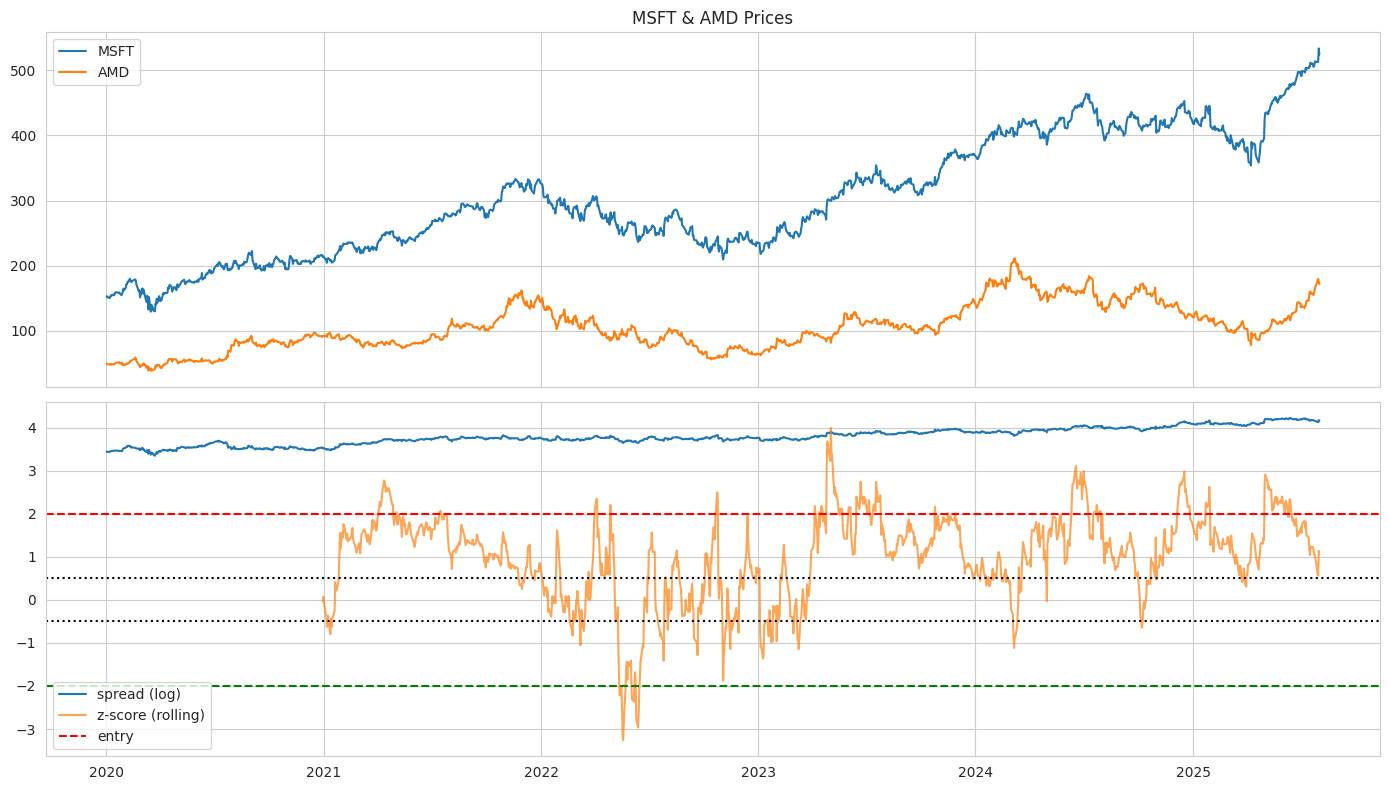

✅ Saved plot: artifacts/run_20250916_183216/plots/spread_zscore_basic_MSFT_AMD.png


In [9]:
pair = top_pairs.iloc[0]
a, b = pair["ticker_a"], pair["ticker_b"]
beta = betas_used[(a, b)]
spread = spreads[(a, b)]
z = zs[(a, b)]

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
prices[[a, b]].plot(ax=axes[0], title=f"{a} & {b} Prices")
axes[0].legend()

axes[1].plot(spread.index, spread.values, label="spread (log)")
axes[1].plot(z.index, z.values, label="z-score (rolling)", alpha=0.7)
axes[1].axhline(CONFIG["entry_z"], color='r', linestyle='--', label="entry")
axes[1].axhline(-CONFIG["entry_z"], color='g', linestyle='--')
axes[1].axhline(CONFIG["exit_z"], color='k', linestyle=':')
axes[1].axhline(-CONFIG["exit_z"], color='k', linestyle=':')
axes[1].legend()
plt.tight_layout()
# show & save this basic version
fig_name = f"spread_zscore_basic_{a}_{b}"
save_and_show(fig, fig_name)

### Signal Generation (symmetric exits)

In [10]:
def generate_signals(z, entry_z=2.0, exit_z=0.5):
    """
    Returns Series of positions: +1 long spread (long A, short B), -1 short spread.
    Entry when z ≥ entry or z ≤ -entry. Exit when |z| ≤ exit.
    """
    pos = pd.Series(0, index=z.index, dtype="int8")
    current = 0
    for t in range(len(z)):
        zt = z.iat[t]
        if current == 0:
            if zt >= entry_z:
                current = -1   # short spread
            elif zt <= -entry_z:
                current = 1    # long spread
        else:
            if abs(zt) <= exit_z:
                current = 0
        pos.iat[t] = current
    return pos

sig = generate_signals(z.dropna(), CONFIG["entry_z"], CONFIG["exit_z"])
display(sig.value_counts())

-1    586
 0    539
 1     27
Name: count, dtype: int64

### Backtester (single pair)

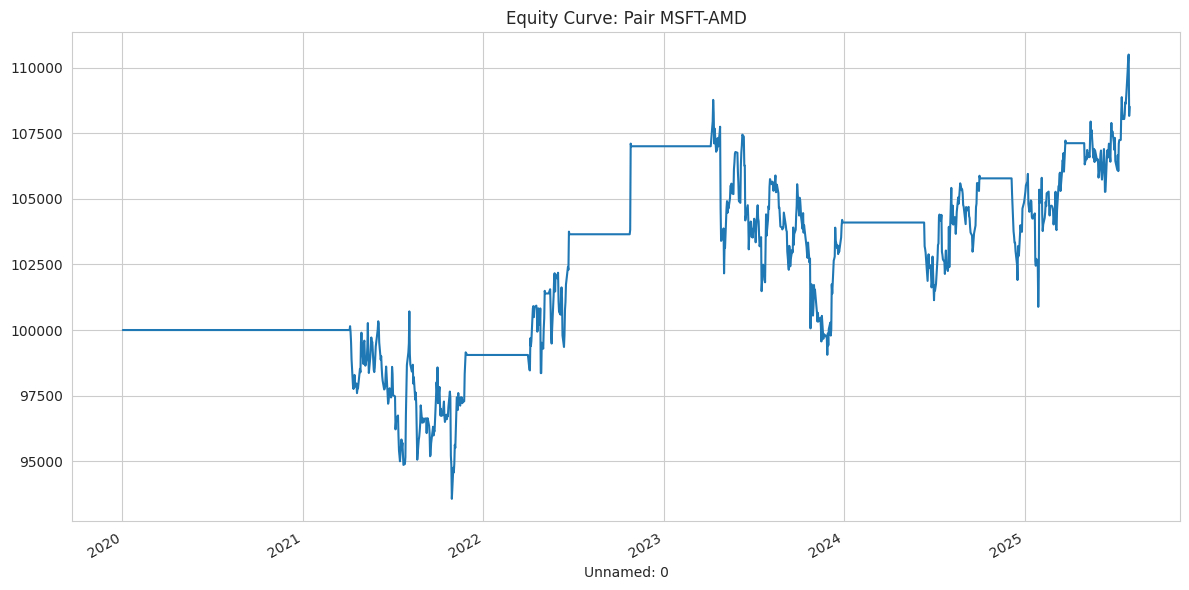

✅ Saved plot: artifacts/run_20250916_183216/plots/equity_curve_MSFT_AMD.png


,entry_date,exit_date,pnl,duration
0,2021-04-06,2021-11-29,-1095.339224,237
1,2022-04-04,2022-05-06,2900.020371,32
2,2022-05-16,2022-06-24,2093.765675,39
3,2022-10-25,2022-10-27,3181.942973,2
4,2023-04-10,2023-12-29,-3846.482512,263


In [11]:
def backtest_pair(prices, a, b, beta, z, signals, tc=0.001, notional=100_000):
    """
    prices: original close prices
    notional: capital allocated to the pair
    Position applies next bar (signals shifted by 1).
    No daily rebalancing of units; uses returns with fixed weights per unit pos.
    """
    px_a, px_b = prices[a], prices[b]
    ret_a, ret_b = px_a.pct_change(), px_b.pct_change()

    pos = signals.shift(1).reindex(px_a.index).fillna(0)  # next-bar execution
    w_a = 0.5
    w_b = -0.5 * beta

    # daily portfolio return on notional when in position
    port_ret = (w_a * ret_a + w_b * ret_b) * pos
    port_ret = port_ret.replace([np.inf, -np.inf], np.nan).fillna(0)

    # trading cost on position changes (round-trip proportion of notional)
    turns = pos.diff().abs().fillna(0)  # 1 when entering or exiting
    daily_cost = turns * tc

    net_ret = port_ret - daily_cost
    pnl_net = net_ret * notional
    nav = pnl_net.cumsum() + notional

    # trades ledger
    trades_ledger, in_trade = [], False
    for t in range(len(pos)):
        if not in_trade and pos.iat[t] != 0:
            in_trade, entry_date, entry_nav = True, pos.index[t], nav.iat[t]
        elif in_trade and pos.iat[t] == 0:
            exit_date, exit_nav = pos.index[t], nav.iat[t]
            trades_ledger.append({
                "entry_date": entry_date,
                "exit_date": exit_date,
                "pnl": float(exit_nav - entry_nav),
                "duration": (exit_date - entry_date).days
            })
            in_trade = False

    trades_df = pd.DataFrame(trades_ledger)
    return {"nav": nav, "pnl_net": pnl_net, "trades": trades_df, "cost": daily_cost * notional}

# Demo on top pair
demo = backtest_pair(prices, a, b, beta, z, sig, tc=CONFIG["transaction_cost"], notional=100_000)
fig = plt.figure()
demo["nav"].plot(title=f"Equity Curve: Pair {a}-{b}")
plt.tight_layout()
save_and_show(fig, f"equity_curve_{a}_{b}")
display(demo["trades"].head())

### Portfolio Backtest (aggregate NAV)

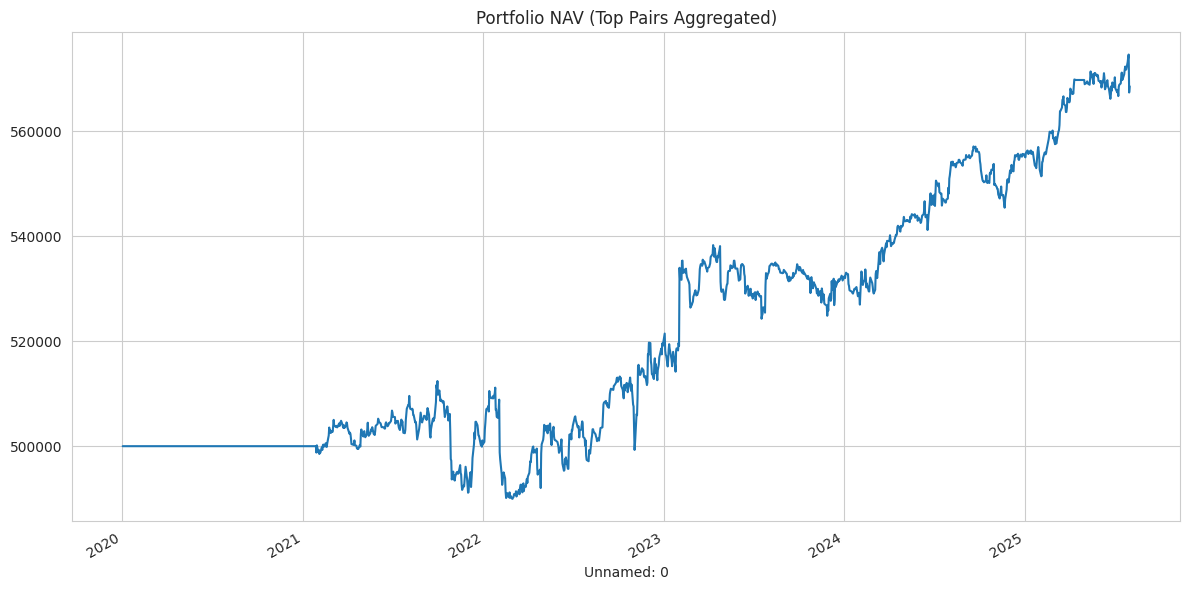

✅ Saved plot: artifacts/run_20250916_183216/plots/portfolio_nav.png


,entry_date,exit_date,pnl,duration,pair
0,2021-04-06,2021-11-29,-1095.339224,237,MSFT-AMD
1,2022-04-04,2022-05-06,2900.020371,32,MSFT-AMD
2,2022-05-16,2022-06-24,2093.765675,39,MSFT-AMD
3,2022-10-25,2022-10-27,3181.942973,2,MSFT-AMD
4,2023-04-10,2023-12-29,-3846.482512,263,MSFT-AMD


In [12]:
def portfolio_backtest(prices, top_pairs_df, betas, zdict, entry_z, exit_z, tc, notional_per_pair=100_000):
    cum_pnl = pd.Series(0.0, index=prices.index)
    all_trades = []

    for _, row in top_pairs_df.iterrows():
        aa, bb = row["ticker_a"], row["ticker_b"]
        beta_ = betas[(aa, bb)]
        z_ = zdict[(aa, bb)].reindex(prices.index).ffill()
        signals_ = generate_signals(z_, entry_z, exit_z)
        res = backtest_pair(prices, aa, bb, beta_, z_, signals_, tc=tc, notional=notional_per_pair)

        pair_pnl = res["nav"] - notional_per_pair
        cum_pnl = cum_pnl.add(pair_pnl, fill_value=0)

        tr = res["trades"].copy()
        tr["pair"] = f"{aa}-{bb}"
        all_trades.append(tr)

    n_pairs = len(top_pairs_df)
    portfolio_nav = cum_pnl + notional_per_pair * n_pairs
    trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()
    return {"nav": portfolio_nav, "trades": trades_df}

portfolio_res = portfolio_backtest(
    prices,
    top_pairs.rename(columns={"ticker_a": "ticker_a", "ticker_b": "ticker_b"}),
    betas_used,
    zs,
    CONFIG["entry_z"],
    CONFIG["exit_z"],
    CONFIG["transaction_cost"],
    notional_per_pair=100_000
)
fig = plt.figure()
portfolio_res["nav"].plot(title="Portfolio NAV (Top Pairs Aggregated)")
plt.tight_layout()
save_and_show(fig, "portfolio_nav")
display(portfolio_res["trades"].head())


### Performance Metrics

In [13]:
def performance_metrics(nav_series):
    # Clean daily returns
    returns = nav_series.pct_change()
    returns = returns.replace([np.inf, -np.inf], np.nan).dropna()

    if returns.empty:
        return {"CAGR": np.nan, "AnnVol": np.nan, "Sharpe": np.nan, "MaxDrawdown": np.nan}

    ann_ret = (1 + returns.mean()) ** 252 - 1
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan

    peak = nav_series.cummax()
    dd = (nav_series - peak) / peak
    maxdd = dd.min()

    return {"CAGR": ann_ret, "AnnVol": ann_vol, "Sharpe": sharpe, "MaxDrawdown": maxdd}

metrics = performance_metrics(portfolio_res["nav"])
display(metrics)

with open(os.path.join(CONFIG["out_dir"], "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

{'CAGR': np.float64(0.024091936664365043),
 'AnnVol': np.float64(0.037788503815875604),
 'Sharpe': np.float64(0.6375467200753158),
 'MaxDrawdown': np.float64(-0.043785934005786266)}

### Trade Diagnostics

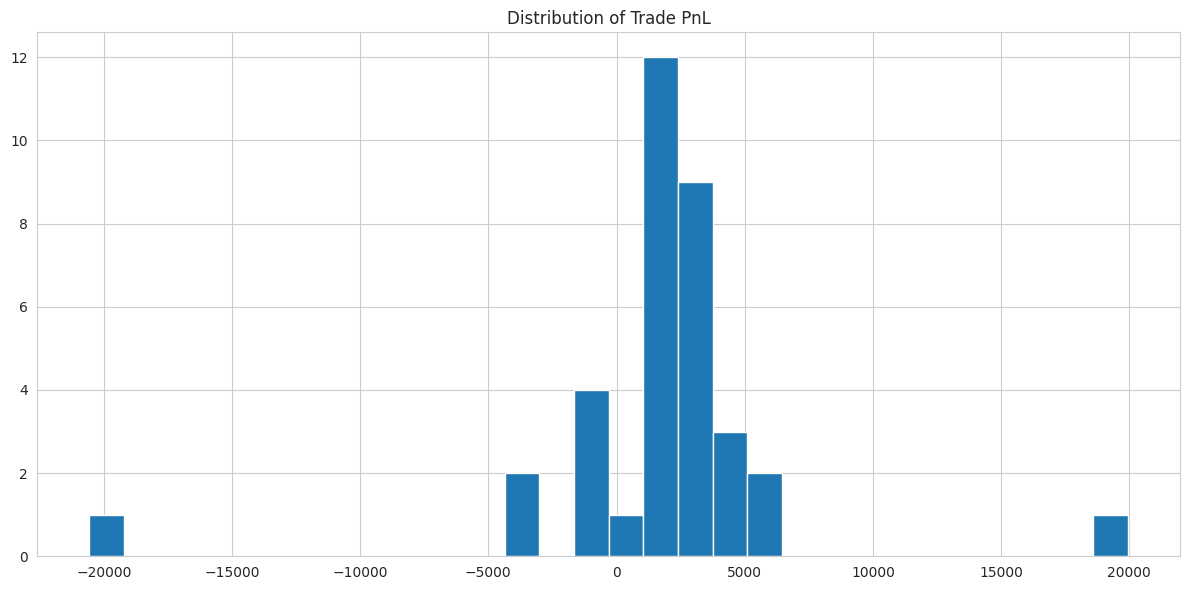

✅ Saved plot: artifacts/run_20250916_183216/plots/trade_pnl_distribution_all_pairs.png


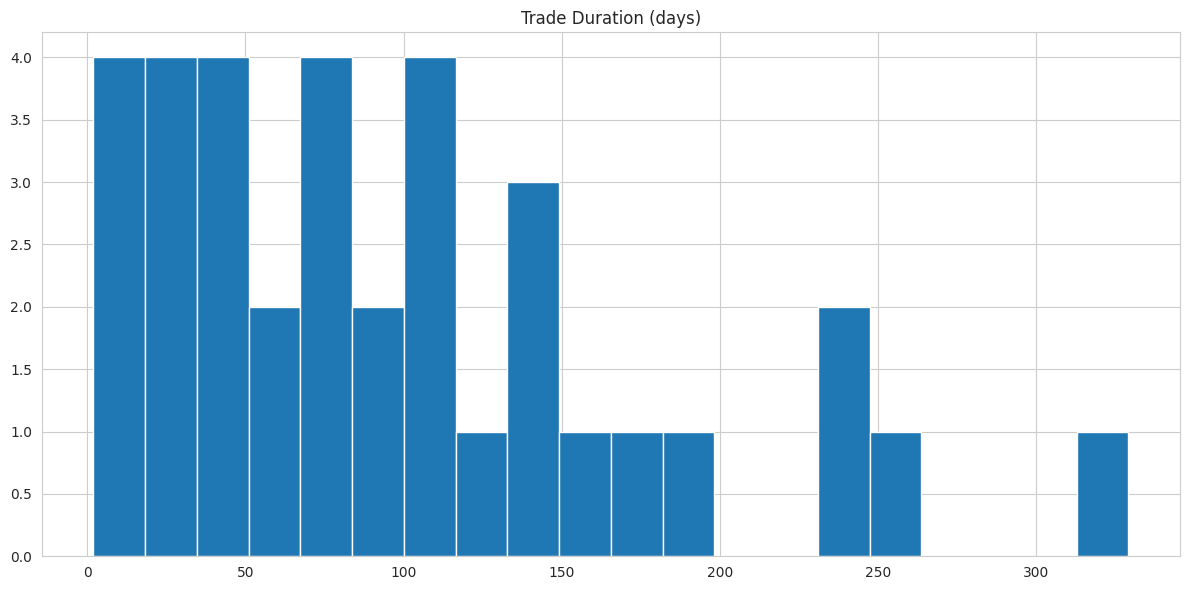

✅ Saved plot: artifacts/run_20250916_183216/plots/trade_duration_distribution.png


In [14]:
trades = portfolio_res["trades"]
if not trades.empty:
    fig = plt.figure()
    trades["pnl"].hist(bins=30)
    plt.title("Distribution of Trade PnL")
    plt.tight_layout()
    save_and_show(fig, "trade_pnl_distribution_all_pairs")
    fig = plt.figure()
    trades["duration"].hist(bins=20)
    plt.title("Trade Duration (days)")
    plt.tight_layout()
    save_and_show(fig, "trade_duration_distribution")
    trades.to_csv(os.path.join(CONFIG["out_dir"], "trades.csv"), index=False)
else:
    print("No trades recorded for top pairs with the given thresholds.")

### Sensitivity (entry & cost)

In [15]:
def sensitivity_entry_cost(prices, top_pairs_df, betas, zdict,
                           entries=(1.5, 2.0, 2.5), costs=(0.0005, 0.001, 0.003)):
    rows = []
    for e in entries:
        for c in costs:
            res = portfolio_backtest(prices, top_pairs_df, betas, zdict, e, CONFIG["exit_z"], c, notional_per_pair=100_000)
            m = performance_metrics(res["nav"])
            rows.append({"entry_z": e, "tc": c, **m})
    return pd.DataFrame(rows)

sens = sensitivity_entry_cost(prices, top_pairs.rename(columns={"ticker_a":"ticker_a","ticker_b":"ticker_b"}), betas_used, zs)
display(sens)
sens.to_csv(os.path.join(CONFIG["out_dir"], "sensitivity.csv"), index=False)

,entry_z,tc,CAGR,AnnVol,Sharpe,MaxDrawdown
0,1.5,0.0005,0.032418,0.040780,0.794968,-0.045380
1,1.5,0.0010,0.030500,0.041007,0.743767,-0.045861
2,1.5,0.0030,0.022659,0.042001,0.539492,-0.047804
3,2.0,0.0005,0.025266,0.037664,0.670825,-0.042963
4,2.0,0.0010,0.024092,0.037789,0.637547,-0.043786
5,2.0,0.0030,0.019336,0.038333,0.504417,-0.047092
6,2.5,0.0005,0.026858,0.034912,0.769326,-0.045827
7,2.5,0.0010,0.026061,0.034987,0.744874,-0.046655
8,2.5,0.0030,0.022842,0.035315,0.646795,-0.049981


### Save Key Outputs & Executive Summary


=== Executive summary ===
- Scanned 66 pairs from 12 tech stocks; selected top 5 pairs.
- Portfolio backtest: CAGR=2.41%, Sharpe=0.64, Max DD=-4.38%.
- z-entry=2.0, z-exit=0.5, tc=0.10% (round-trip).
Artifacts saved in artifacts/run_20250916_183216


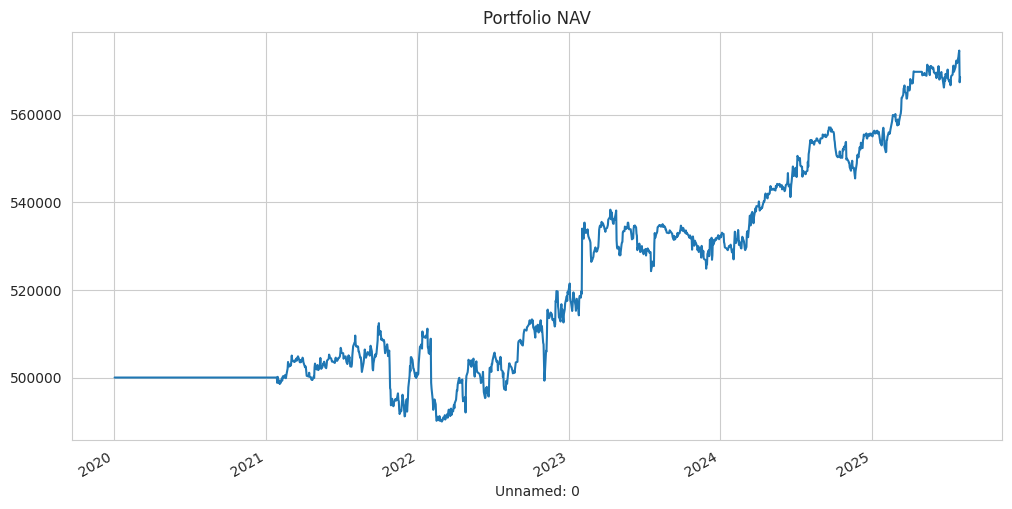

In [16]:
agg.to_csv(os.path.join(CONFIG["out_dir"], "pairs_ranked.csv"), index=False)
top_pairs.to_csv(os.path.join(CONFIG["out_dir"], "top_pairs.csv"), index=False)
fig = plt.figure(); portfolio_res["nav"].plot(); plt.title("Portfolio NAV"); plt.savefig(os.path.join(CONFIG["out_dir"], "portfolio_nav.png"))

summary = {
    "run_id": RUN_ID,
    "n_assets": len(tickers),
    "n_pairs_scanned": len(list(itertools.combinations(tickers, 2))),
    "top_pairs_found": len(top_pairs),
    "metrics": metrics
}
with open(os.path.join(CONFIG["out_dir"], "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n=== Executive summary ===")
print(f"- Scanned {summary['n_pairs_scanned']} pairs from {summary['n_assets']} tech stocks; selected top {summary['top_pairs_found']} pairs.")
print(f"- Portfolio backtest: CAGR={metrics['CAGR']:.2%}, Sharpe={metrics['Sharpe']:.2f}, Max DD={metrics['MaxDrawdown']:.2%}.")
print(f"- z-entry={CONFIG['entry_z']}, z-exit={CONFIG['exit_z']}, tc={CONFIG['transaction_cost']:.2%} (round-trip).")
print("Artifacts saved in", CONFIG["out_dir"])

### Compute Train / OOS Sharpe for scanned pairs

#### We'll compute Train / Test split at 70/30 and compute Sharpe for all pairs in agg

In [17]:
n = len(prices)
train_n = int(n * 0.7)
train_idx = prices.index[:train_n]
test_idx = prices.index[train_n:]
split_date = prices.index[train_n] if train_n < n else prices.index[-1]
print(f"[INFO] Train days: {len(train_idx)}, Test days: {len(test_idx)}; split_date={split_date.date()}")

def compute_pair_train_oos_sharpe(a, b, beta, train_idx, test_idx, win=CONFIG["train_window"], tc=CONFIG["transaction_cost"], notional=100000):
    # compute spread & z across full range using provided beta
    spread_full = np.log(prices[a]) - beta * np.log(prices[b])
    roll_mean = spread_full.rolling(win, min_periods=win).mean()
    roll_std  = spread_full.rolling(win, min_periods=win).std()
    z_full = (spread_full - roll_mean) / roll_std

    # signals
    signals_full = generate_signals(z_full.ffill().dropna(), CONFIG["entry_z"], CONFIG["exit_z"])
    # align signals to prices index, fill NaN with 0 (no position)
    signals_full = signals_full.reindex(prices.index).fillna(0)

    # train portion
    try:
        res_train = backtest_pair(
            prices.loc[train_idx], a, b, beta,
            z_full.reindex(train_idx).ffill(),
            signals_full.reindex(train_idx).fillna(0),
            tc=tc, notional=notional
        )
        train_nav = res_train["nav"]
        train_metrics = performance_metrics(train_nav)
        train_sharpe = train_metrics["Sharpe"]
    except Exception:
        train_sharpe = np.nan

    # test portion
    try:
        res_test = backtest_pair(
            prices.loc[test_idx], a, b, beta,
            z_full.reindex(test_idx).ffill(),
            signals_full.reindex(test_idx).fillna(0),
            tc=tc, notional=notional
        )
        test_nav = res_test["nav"]
        test_metrics = performance_metrics(test_nav)
        test_sharpe = test_metrics["Sharpe"]
    except Exception:
        test_sharpe = np.nan

    return train_sharpe, test_sharpe

# iterate through aggregated pairs (limited to those that had entries in agg)
results_rows = []
for _, row in agg.iterrows():
    aa, bb = row["a"], row["b"]
    beta_mean = row["mean_beta"]
    try:
        tr_sh, oos_sh = compute_pair_train_oos_sharpe(aa, bb, beta_mean, train_idx, test_idx)
    except Exception:
        tr_sh, oos_sh = np.nan, np.nan
    results_rows.append({"Pair": f"{aa}-{bb}", "TrainSharpe": tr_sh, "OOSSharpe": oos_sh})

results_df = pd.DataFrame(results_rows).dropna(how="all")
results_df.to_csv(os.path.join(CONFIG["out_dir"], "train_vs_oos_sharpe_all_pairs.csv"), index=False)
print("[OK] Saved pairwise Train vs OOS Sharpe for scanned pairs.")


[INFO] Train days: 982, Test days: 421; split_date=2023-11-27
[OK] Saved pairwise Train vs OOS Sharpe for scanned pairs.


### Plot: Sharpe ranking (top 5 by TrainSharpe)

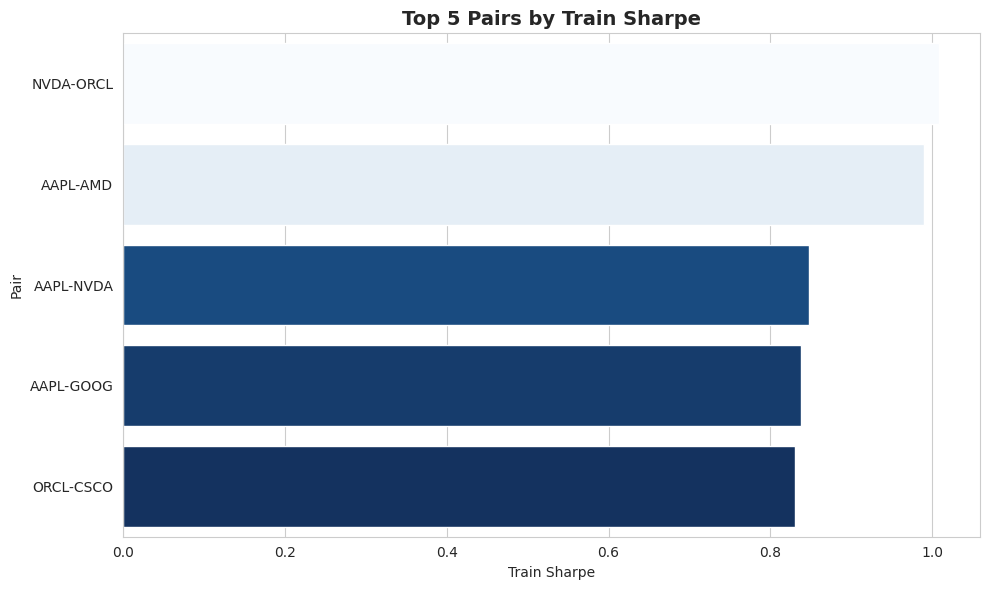

✅ Saved plot: artifacts/run_20250916_183216/plots/sharpe_ranking.png


In [18]:
# create a train-sharpe ranking for plotting (use results_df)
rank_df = results_df.copy()
# fallback: if TrainSharpe is all NaN, use agg fraction significant as proxy (rare)
if rank_df["TrainSharpe"].notna().sum() == 0:
    rank_df = rank_df.merge(
        agg.assign(Pair=agg["a"] + "-" + agg["b"])[["Pair","frac_significant"]],
        on="Pair", how="left"
    )
    rank_df["TrainSharpe"] = rank_df["frac_significant"]

# top 5
rank_plot_df = rank_df.sort_values("TrainSharpe", ascending=False).head(5).copy()
rank_plot_df["Sharpe"] = rank_plot_df["TrainSharpe"]

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(
    x="Sharpe", y="Pair",
    data=rank_plot_df,
    hue="Sharpe",               # gradient based on Sharpe values
    palette="Blues_r",
    dodge=False, legend=False,  # keep it clean
    ax=ax
)
ax.set_title("Top 5 Pairs by Train Sharpe", fontsize=14, weight="bold")
ax.set_xlabel("Train Sharpe")
ax.set_ylabel("Pair")
plt.tight_layout()
save_and_show(fig, "sharpe_ranking")

### Plot: Train vs OOS scatter

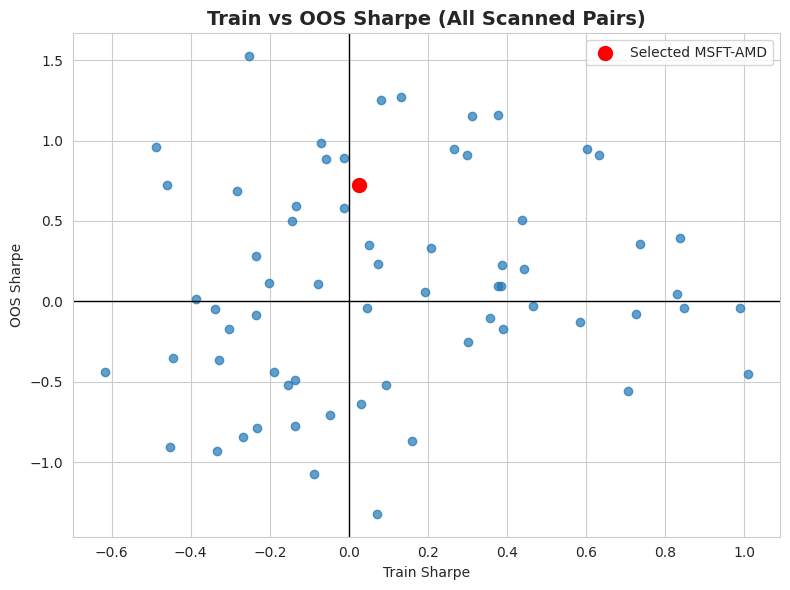

✅ Saved plot: artifacts/run_20250916_183216/plots/train_vs_oos_scatter.png


In [19]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(results_df["TrainSharpe"], results_df["OOSSharpe"], alpha=0.7)
# highlight best chosen pair (top_pairs first)
best_pair_name = f"{top_pairs.iloc[0]['ticker_a']}-{top_pairs.iloc[0]['ticker_b']}"
best_row = results_df[results_df["Pair"]==best_pair_name]
if not best_row.empty:
    ax.scatter(best_row["TrainSharpe"].values[0], best_row["OOSSharpe"].values[0], color="red", s=100, label=f"Selected {best_pair_name}")
ax.axhline(0, color="black", linewidth=1)
ax.axvline(0, color="black", linewidth=1)
ax.set_xlabel("Train Sharpe")
ax.set_ylabel("OOS Sharpe")
ax.set_title("Train vs OOS Sharpe (All Scanned Pairs)", fontsize=14, weight="bold")
ax.legend()
plt.tight_layout()
save_and_show(fig, "train_vs_oos_scatter")

### Plot: Spread & Zscore (polished) for best pair and mark signals

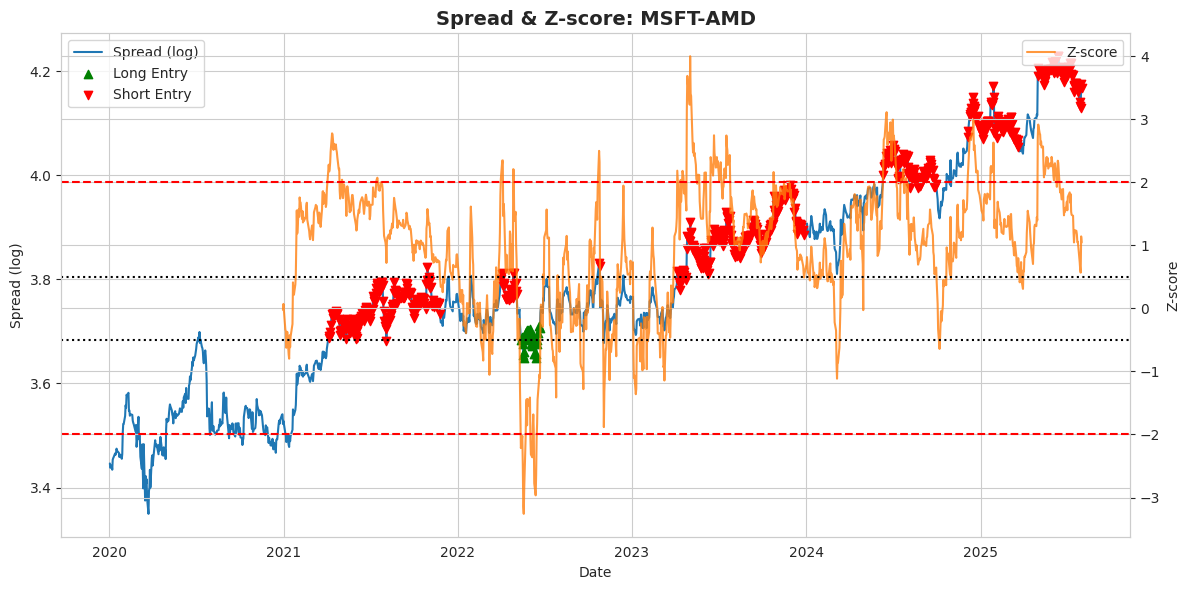

✅ Saved plot: artifacts/run_20250916_183216/plots/spread_zscore_MSFT_AMD.png


In [20]:
def prepare_best_pair_df(a, b, beta, win):
    spread_full = np.log(prices[a]) - beta * np.log(prices[b])
    roll_mean = spread_full.rolling(win, min_periods=win).mean()
    roll_std  = spread_full.rolling(win, min_periods=win).std()
    z_full = (spread_full - roll_mean) / roll_std
    z_full = z_full.ffill()  # ✅ modern fix for deprecated fillna(method="ffill")
    
    signals_full = generate_signals(z_full, CONFIG["entry_z"], CONFIG["exit_z"])
    longs = signals_full == 1
    shorts = signals_full == -1
    
    dfp = pd.DataFrame({
        "spread": spread_full,
        "zscore": z_full,
        "longs": longs,
        "shorts": shorts
    })
    return dfp

best_a, best_b = top_pairs.iloc[0]["ticker_a"], top_pairs.iloc[0]["ticker_b"]
best_beta = betas_used[(best_a, best_b)]
best_df = prepare_best_pair_df(best_a, best_b, best_beta, win)

# spread + zscore (polished)
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(best_df.index, best_df["spread"], label="Spread (log)", color="tab:blue")

ax2 = ax.twinx()
ax2.plot(best_df.index, best_df["zscore"], color="tab:orange", label="Z-score", alpha=0.8)

# mark entries
ax.scatter(best_df.index[best_df["longs"]], best_df["spread"][best_df["longs"]],
           marker="^", color="green", label="Long Entry", zorder=5)
ax.scatter(best_df.index[best_df["shorts"]], best_df["spread"][best_df["shorts"]],
           marker="v", color="red", label="Short Entry", zorder=5)

# horizontal threshold lines
ax2.axhline(CONFIG["entry_z"], color="red", linestyle="--")
ax2.axhline(-CONFIG["entry_z"], color="red", linestyle="--")
ax2.axhline(CONFIG["exit_z"], color="black", linestyle=":")
ax2.axhline(-CONFIG["exit_z"], color="black", linestyle=":")

ax.set_title(f"Spread & Z-score: {best_a}-{best_b}", fontsize=14, weight="bold")
ax.set_xlabel("Date")
ax.set_ylabel("Spread (log)")
ax2.set_ylabel("Z-score")

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
save_and_show(fig, f"spread_zscore_{best_a}_{best_b}")

### Plot: Cumulative PnL for best pair (train vs test separation)

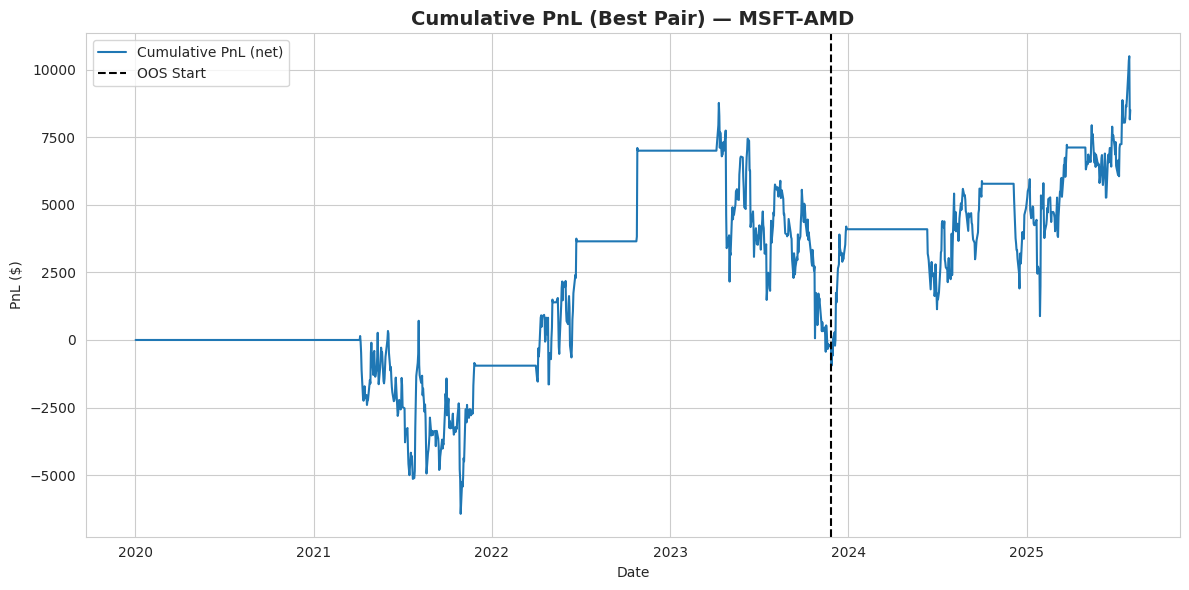

✅ Saved plot: artifacts/run_20250916_183216/plots/cum_pnl_MSFT_AMD.png


In [21]:
# Construct cumulative PnL for best pair using earlier demo or recompute
# We'll recompute to ensure alignment with train/test split
signals_full = generate_signals(best_df["zscore"], CONFIG["entry_z"], CONFIG["exit_z"])
res_full = backtest_pair(prices, best_a, best_b, best_beta, best_df["zscore"], signals_full, tc=CONFIG["transaction_cost"], notional=100000)
cum_nav = res_full["nav"]
cum_pnl = cum_nav - 100000

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(cum_pnl.index, cum_pnl.values, label="Cumulative PnL (net)", color="tab:blue")
ax.axvline(split_date, color="black", linestyle="--", label="OOS Start")
ax.set_title(f"Cumulative PnL (Best Pair) — {best_a}-{best_b}", fontsize=14, weight="bold")
ax.set_xlabel("Date"); ax.set_ylabel("PnL ($)")
ax.legend()
plt.tight_layout()
save_and_show(fig, f"cum_pnl_{best_a}_{best_b}")

### Plot: Trade-by-Trade returns histogram for best pair

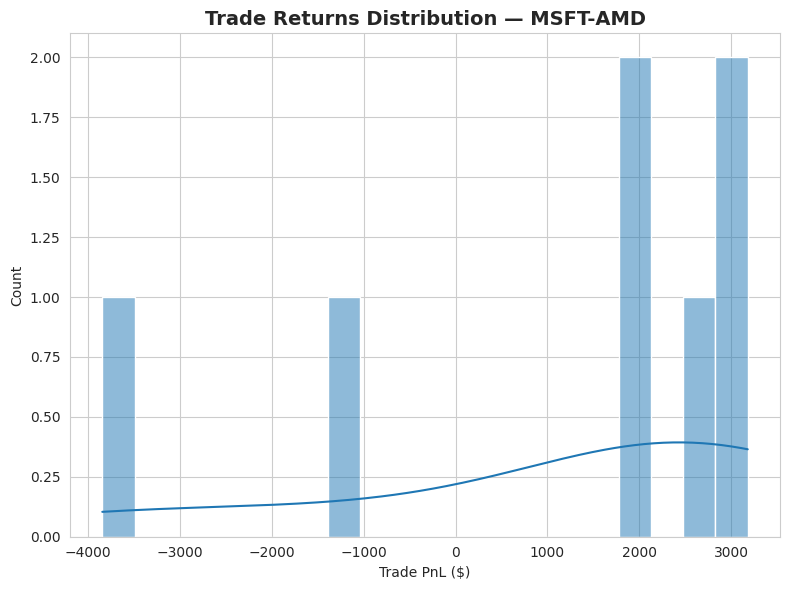

✅ Saved plot: artifacts/run_20250916_183216/plots/trade_histogram_MSFT_AMD.png
[OK] Saved trade log for best pair: artifacts/run_20250916_183216/MSFT-AMD_trades.csv


In [22]:
best_trades = res_full["trades"]
if not best_trades.empty:
    fig, ax = plt.subplots(figsize=(8,6))
    sns.histplot(best_trades["pnl"], bins=20, kde=True, ax=ax, color="tab:blue")
    ax.set_title(f"Trade Returns Distribution — {best_a}-{best_b}", fontsize=14, weight="bold")
    ax.set_xlabel("Trade PnL ($)"); ax.set_ylabel("Count")
    plt.tight_layout()
    save_and_show(fig, f"trade_histogram_{best_a}_{best_b}")
    # save trade log
    best_trades.to_csv(os.path.join(CONFIG["out_dir"], f"{best_a}-{best_b}_trades.csv"), index=False)
    print(f"[OK] Saved trade log for best pair: {os.path.join(CONFIG['out_dir'], f'{best_a}-{best_b}_trades.csv')}")
else:
    print("[INFO] No trades for best pair to plot histogram.")

### Final save of key artifacts

In [23]:
agg.to_csv(os.path.join(CONFIG["out_dir"], "pairs_ranked.csv"), index=False)
top_pairs.to_csv(os.path.join(CONFIG["out_dir"], "top_pairs.csv"), index=False)
results_df.to_csv(os.path.join(CONFIG["out_dir"], "train_vs_oos_sharpe_overview.csv"), index=False)
sens.to_csv(os.path.join(CONFIG["out_dir"], "sensitivity.csv"), index=False)
with open(os.path.join(CONFIG["out_dir"], "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print("\n[ALL DONE] All plots saved in:", PLOTS_DIR)
print("Executive summary and CSVs saved in:", CONFIG["out_dir"])


[ALL DONE] All plots saved in: artifacts/run_20250916_183216/plots
Executive summary and CSVs saved in: artifacts/run_20250916_183216
